In [1]:
from astropy.io import ascii
from astropy.table import Table

import numpy as np
import h5py

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

from scipy import spatial
from scipy.ndimage import label
from scipy.ndimage.filters import uniform_filter, gaussian_filter

from scipy import stats


import illustris_python as il
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy import units as u

import tqdm

import pickle

In [2]:
basePath = './sims.TNG/TNG300-1/output/'

In [3]:
snaps_full = np.array([99, 91, 84, 78, 72, 67, 63, 59, 56, 53, 50, 40, 33])
zs_full = np.array([0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00, 1.50, 2.00])
scale_factors = 1 / (1 + zs_full)
h = 0.704

In [4]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

In [6]:
# mass_bins = np.arange(13.0, 14.0, 0.2)
# mass_bins = np.arange(14.0, 14.6, 0.2)
# mass_bins = np.arange(13.0, 14.5, 0.5)

In [ ]:
#calculate QF in 2 * r200

# mass_bins = np.arange(13.0, 14.5, 0.5)

for isnap, snap in enumerate(snaps_full):

    print(snap)

    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
        gal_mask = MassInRad >= 10**8.5

    SFRs = h5py.File('star_formation_rates.hdf5', 'r')
    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')

    #grid at certain snap
    bins = np.arange(0 , 205000, 500)
    coords = np.array(list(zip(SubhaloPos[:, 0], SubhaloPos[:, 1], SubhaloPos[:, 2])))

    grid, (xedges, yedges, zedges) = np.histogramdd(coords, bins = (bins, bins, bins))
    mean, std = np.mean(grid), np.std(grid)

    filtered = uniform_filter(grid, 3, mode = 'wrap')
    mean2, std2 = np.mean(filtered), np.std(filtered)


    grp_idx = np.where((grp_m200 >= 10**13) & (grp_m200 <= 10**15))[0]

    fofs = []
    fqs = []
    fqs_twice = []
    cpars = [] #concentration parameters
    mem_ids = []
    mem_ids_twice = []
    
    m200s = []

    for idx in grp_idx:

        ########### calculate FoF ###########
        center_pos = grp_pos[idx]

        if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
            continue

        xidx, yidx, zidx = [int(center_pos[i]/500) for i in range(3)]
        subgrid = grid[xidx-20:xidx+20, yidx-20:yidx+20, zidx-20:zidx+20]

        start = np.array([20, 20, 20])
        cands = np.argwhere(subgrid > mean2 + 2 * std2)

        findex = cal_fof(start, cands)
        fof = len(findex) / 40**3
    #     fof = np.sum(subgrid > mean2 + 2 * std2) / 40**3
        fofs.append(fof)

        ########### calculate QF ###########
        mem_mask = SubhaloGrNr == idx
        mem_mask_twice = (center_pos[0] - SubhaloPos[:, 0])**2 + (center_pos[1] - SubhaloPos[:, 1])**2 + (center_pos[2] - SubhaloPos[:, 2])**2 <= (2 * grp_r200[idx])**2

        mem_id = np.where(gal_mask & mem_mask)[0]
        mem_id_twice = np.where(gal_mask & mem_mask_twice)[0]

        mem_ids.append(mem_id)
        mem_ids_twice.append(mem_id_twice)

        sfr_mask = np.isin(SFRs[f'Snapshot_{snap}']['SubfindID'][:], mem_id)
        sfr_mask_twice = np.isin(SFRs[f'Snapshot_{snap}']['SubfindID'][:], mem_id_twice)
        quies_mask = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_mask] / (MassInRad[:][mem_id]) <= 1 / 3 / cosmo.age(z).to(u.yr).value
        quies_mask_twice = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_mask_twice] / (MassInRad[:][mem_id_twice]) <= 1 / 3 / cosmo.age(z).to(u.yr).value

        fq = sum(quies_mask) / len(quies_mask)
        fqs.append(fq)

        fq_twice = sum(quies_mask_twice) / len(quies_mask_twice)
        fqs_twice.append(fq_twice)

        ########### calculate concentration parameter ###########
        cpars.append(halos['c200c'][idx])
        
        ########### galaxy cluster/group halo mass ############
        m200s.append(grp_m200[idx])
    
    
    # save files
    with open(f'./lists_all/m200_snap{snap:03d}', "wb") as f:
        pickle.dump(m200s, f)
    
    with open(f'./lists_all/mem_ids_snap{snap:03d}', "wb") as f:
        pickle.dump(mem_ids, f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "wb") as f:
        pickle.dump(mem_ids_twice, f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "wb") as f:
        pickle.dump(fofs, f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "wb") as f:
        pickle.dump(fqs, f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "wb") as f:
        pickle.dump(fqs_twice, f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "wb") as f:
        pickle.dump(cpars, f)

99


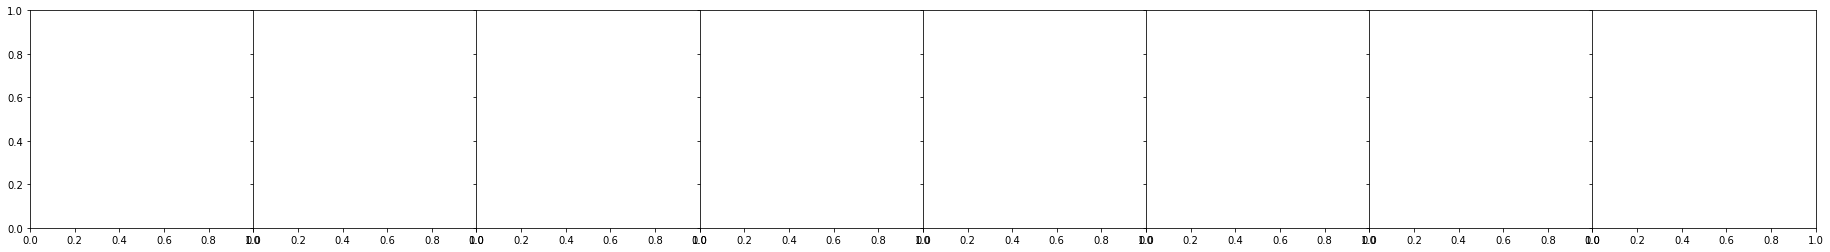

In [17]:
# total

for isnap, snap in enumerate(snaps_full[4:5]):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 8, figsize = (32, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
        
    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)
        
    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)
        
    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)
        
#         colors = ['red', 'orange', 'green', 'blue']
#         for ic, c in enumerate(np.arange(2, 10, 2)):
            
#             nmask = (num_mems >= 10)
#             cmask = (cpars >= c) & (cpars < c + 2)
            
#             mask = nmask & cmask
            
#             #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
#             fof_range = np.arange(0.025, 0.15, 0.025)
#             fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            
#             # bootstrap sampling
#             fqs_median = []
#             fqs_std = []
            
#             for el in fqs_partial:
                
#                 if len(el) == 0:
#                     fqs_median.append(np.nan)
#                     fqs_std.append(np.nan)
#                     continue
                
#                 meds = []
                
#                 for b in range(1000):
#                     bsamp = np.random.choice(el)
#                     meds.append(np.median(bsamp))
                    
#                 fqs_median.append(np.mean(meds))
#                 fqs_std.append(np.std(meds))
                
                    
# #             fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
# #             fqs_median = np.array(fqs_median)
            
#             ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
#             ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
#             ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', color = colors[ic], capsize = 3)
    
    #####overall per mass, per concentration
#         mask = num_mems >= 10
        
#         fof_range = np.arange(0.025, 0.15, 0.025)
#         fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
        
#         fqs_median = []
#         fqs_std = []
        
#         for el in fqs_partial:

#             if len(el) == 0:
#                 fqs_median.append(np.nan)
#                 fqs_std.append(np.nan)
#                 continue

#             meds = []

#             for b in range(1000):
#                 bsamp = np.random.choice(el)
#                 meds.append(np.median(bsamp))

#             fqs_median.append(np.mean(meds))
#             fqs_std.append(np.std(meds))


#         ax[imbin].scatter(fof_range, fqs_median)
#         ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', capsize = 3)
        
# #         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
# #         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
# #         ax[imbin].add_artist(anchor)
# #         ax[imbin].legend()
#         ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.2:.1f}')
#         ax[imbin].set_xlabel('$F_{FoF}$')
#         ax[imbin].set_ylabel('$F_{Quies.}$')
        
#         ax[imbin].set_xlim(0.01, 0.13)
#         ax[imbin].set_ylim(0, 1)
    
# #     fig.supylabel('$F_{Quies.}$')
#     fig.suptitle(f'z = {z:.1f}')

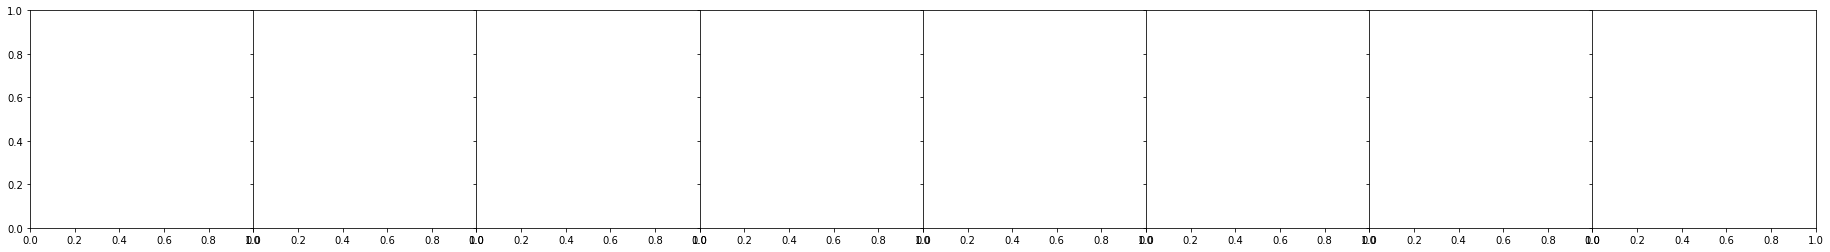

In [25]:
isnap = 4
snap = 67

scale_factor = scale_factors[isnap]
z = zs_full[isnap]

fig, ax = plt.subplots(1, 8, figsize = (32, 4), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0)


with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
    mem_ids = pickle.load(f)
    
with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
    mem_ids_twice = pickle.load(f)

with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
    fofs = pickle.load(f)

with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
    fqs = pickle.load(f)

with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
    fqs_twice = pickle.load(f)

with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
    cpars = pickle.load(f)

#         mem_ids = np.array(mem_ids)
fofs = np.array(fofs)
fqs = np.array(fqs)
fqs_twice = np.array(fqs_twice)
cpars = np.array(cpars)

num_mems = [len(x) for x in mem_ids]
num_mems = np.array(num_mems)

num_mems_twice = [len(x) for x in mem_ids_twice]
num_mems_twice = np.array(num_mems_twice)


(array([1.246e+03, 6.620e+02, 2.100e+02, 8.900e+01, 4.600e+01, 2.900e+01,
        1.900e+01, 1.500e+01, 7.000e+00, 7.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  2.,  18.,  34.,  50.,  66.,  82.,  98., 114., 130., 146., 162.,
        178., 194., 210., 226., 242., 258., 274., 290., 306., 322., 338.,
        354., 370., 386., 402., 418., 434., 450., 466., 482.]),
 [<matplotlib.patches.Polygon at 0x7f91771f0898>])

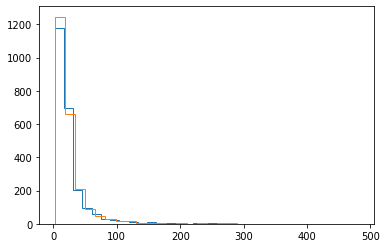

In [28]:
plt.hist(num_mems, bins = 30, histtype = 'step')
plt.hist(num_mems_twice, bins = 30, histtype = 'step')

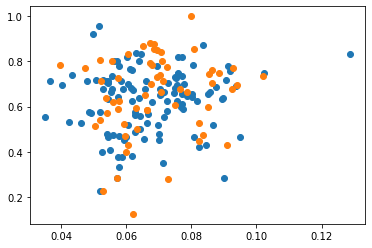

In [43]:
mask = (num_mems >= 20) & (cpars <= 4)
plt.scatter(fofs[mask], fqs_twice[mask])

mask = (num_mems >= 20) & (cpars >= 8)
plt.scatter(fofs[mask], fqs_twice[mask])

(array([  3.,  33., 121., 174., 356., 588., 464., 380., 199.,  30.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [<matplotlib.patches.Polygon at 0x7f9177622e80>])

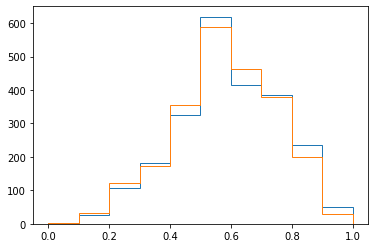

In [24]:
plt.hist(fqs, histtype = 'step')
plt.hist(fqs_twice, histtype = 'step')

## Results

### 0.2 interval

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  retu

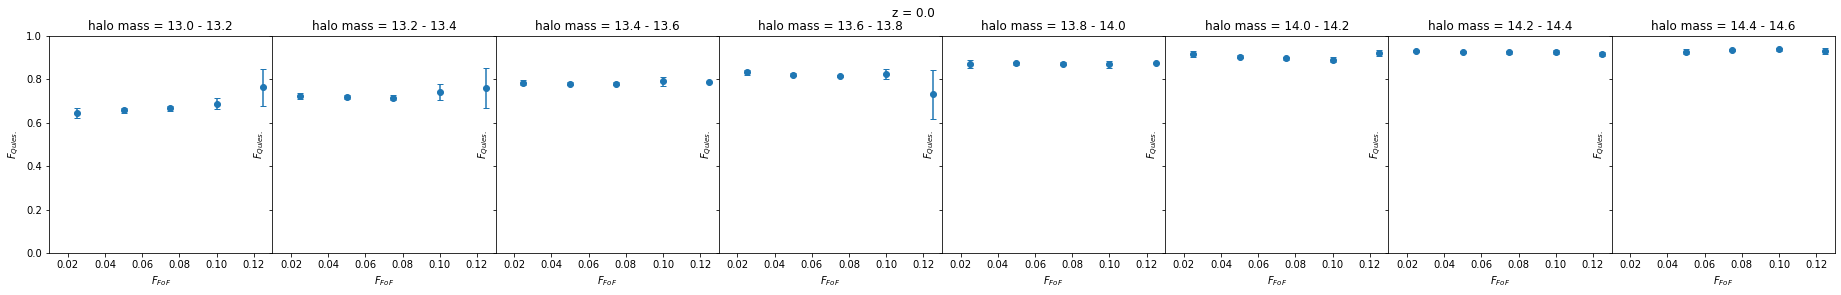

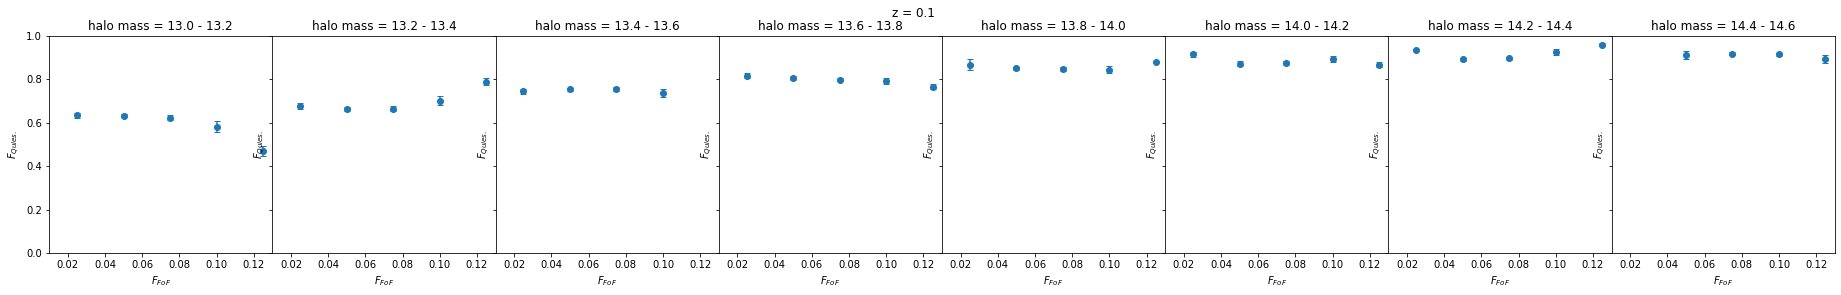

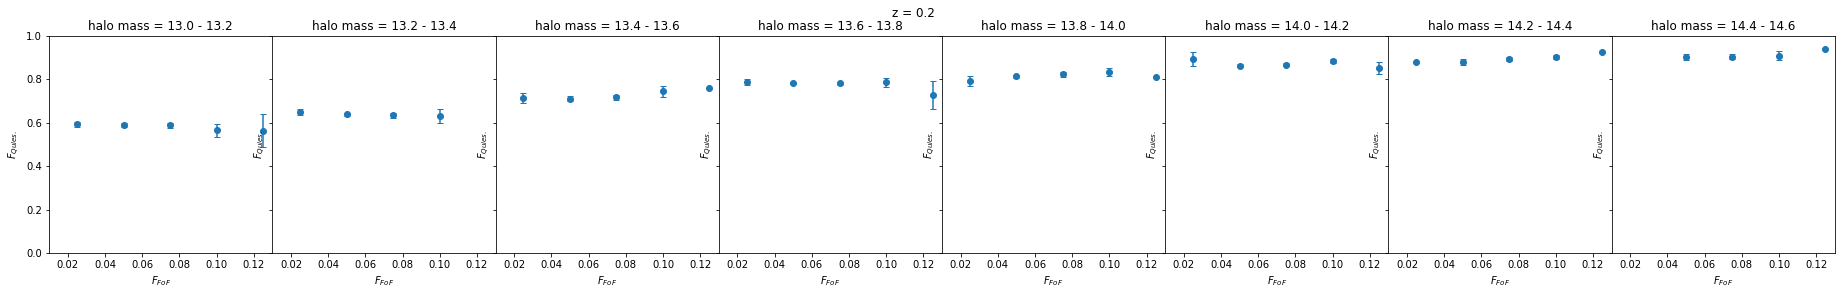

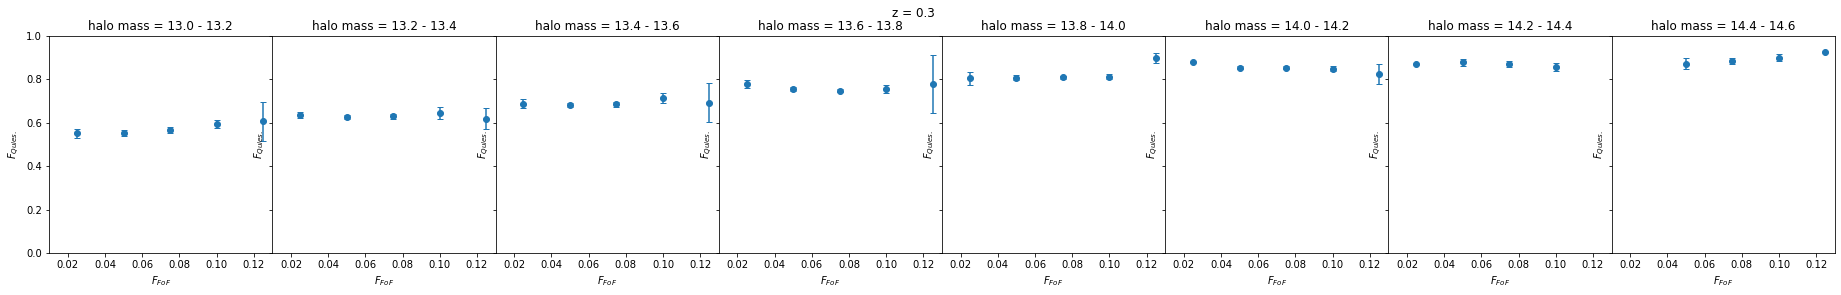

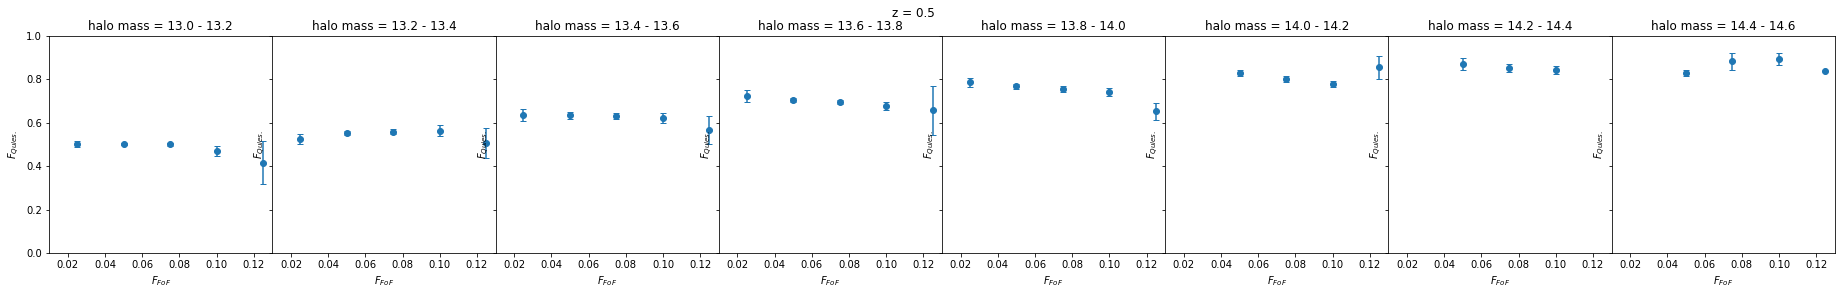

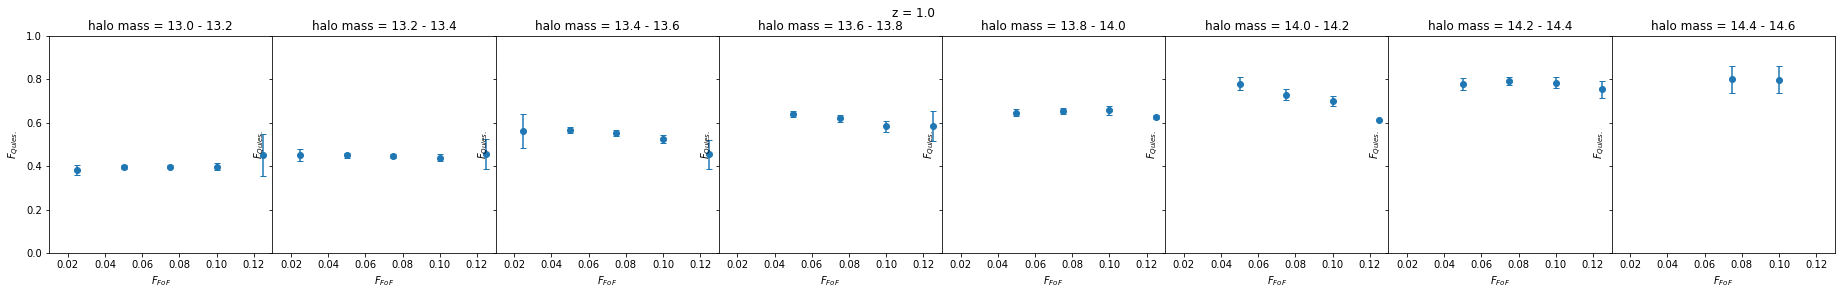

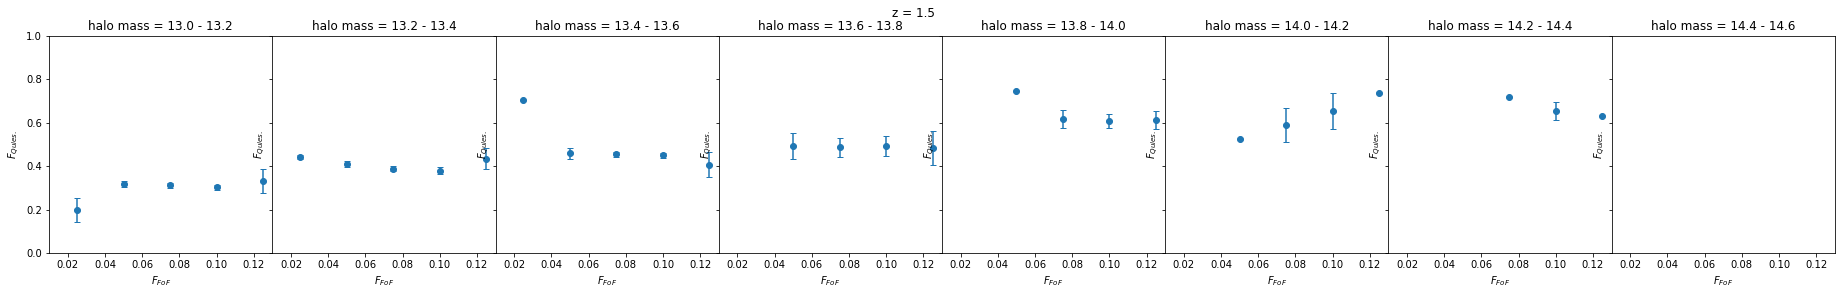

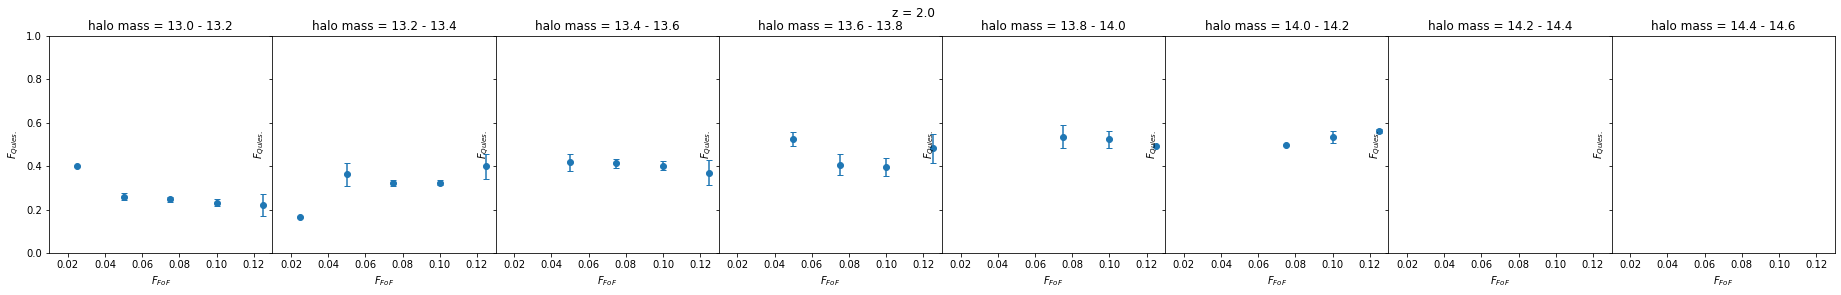

In [51]:
## 0.2 interval
mass_bins = np.arange(13.0, 14.6, 0.2)

for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 8, figsize = (32, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
#         colors = ['red', 'orange', 'green', 'blue']
#         for ic, c in enumerate(np.arange(2, 10, 2)):
            
#             nmask = (num_mems >= 10)
#             cmask = (cpars >= c) & (cpars < c + 2)
            
#             mask = nmask & cmask
            
#             #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
#             fof_range = np.arange(0.025, 0.15, 0.025)
#             fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            
#             # bootstrap sampling
#             fqs_median = []
#             fqs_std = []
            
#             for el in fqs_partial:
                
#                 if len(el) == 0:
#                     fqs_median.append(np.nan)
#                     fqs_std.append(np.nan)
#                     continue
                
#                 meds = []
                
#                 for b in range(1000):
#                     bsamp = np.random.choice(el)
#                     meds.append(np.median(bsamp))
                    
#                 fqs_median.append(np.mean(meds))
#                 fqs_std.append(np.std(meds))
                
                    
# #             fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
# #             fqs_median = np.array(fqs_median)
            
#             ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
#             ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
#             ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', color = colors[ic], capsize = 3)
    
    #####overall per mass, per concentration
        mask = num_mems >= 10
        
        fof_range = np.arange(0.025, 0.15, 0.025)
        fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
        
        fqs_median = []
        fqs_std = []
        
        for el in fqs_partial:

            if len(el) == 0:
                fqs_median.append(np.nan)
                fqs_std.append(np.nan)
                continue

            meds = []

            for b in range(1000):
                bsamp = np.random.choice(el, size = len(el),replace = True)
                meds.append(np.median(bsamp))

            fqs_median.append(np.mean(meds))
            fqs_std.append(np.std(meds))


        ax[imbin].scatter(fof_range, fqs_median)
        ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', capsize = 3)
        
#         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
#         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
#         ax[imbin].add_artist(anchor)
#         ax[imbin].legend()
        ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.2:.1f}')
        ax[imbin].set_xlabel('$F_{FoF}$')
        ax[imbin].set_ylabel('$F_{Quies.}$')
        
        ax[imbin].set_xlim(0.01, 0.13)
        ax[imbin].set_ylim(0, 1)
    
#     fig.supylabel('$F_{Quies.}$')
    fig.suptitle(f'z = {z:.1f}')

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  retu

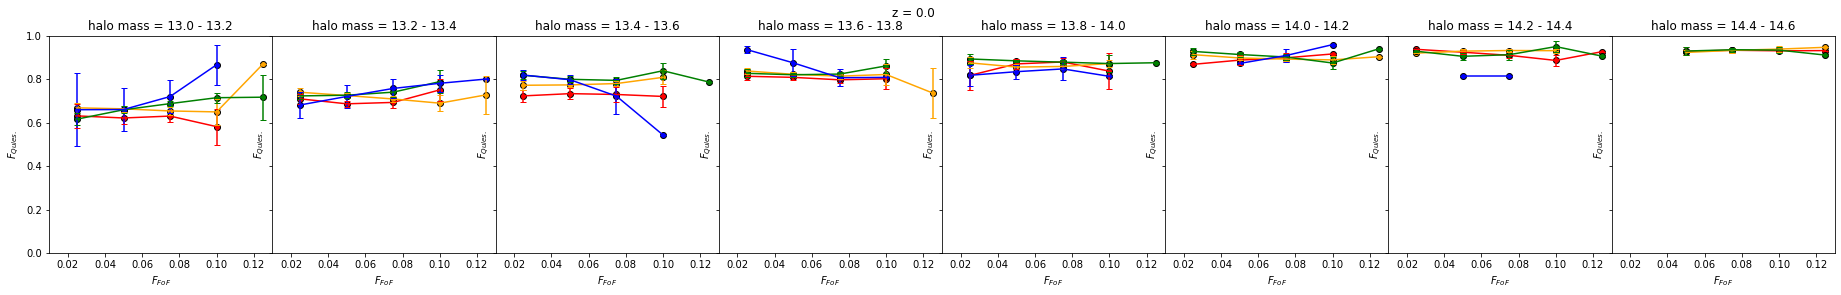

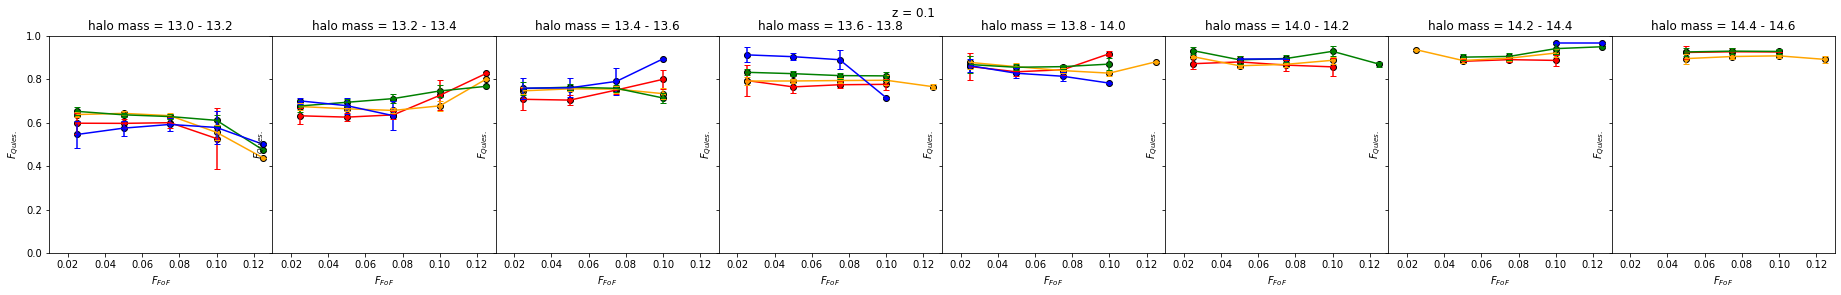

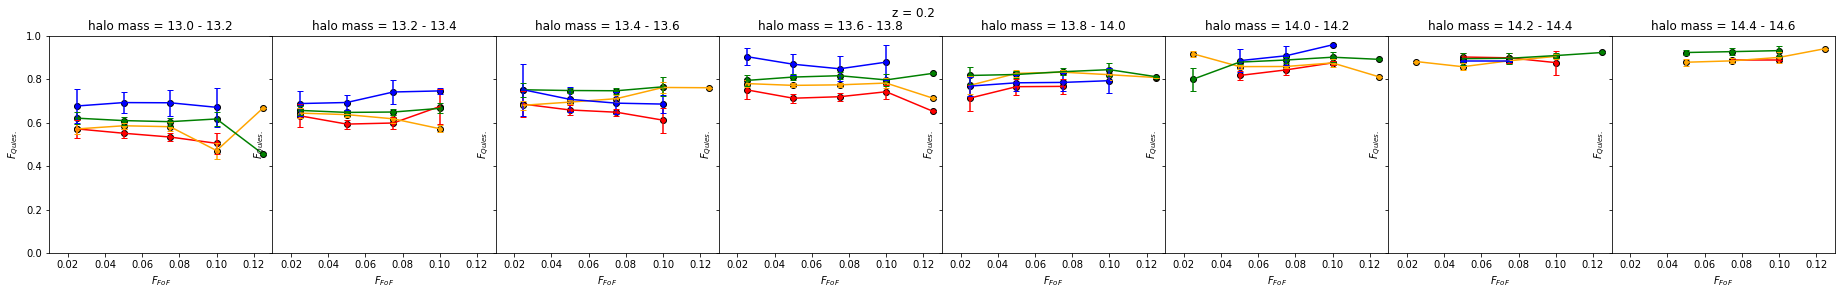

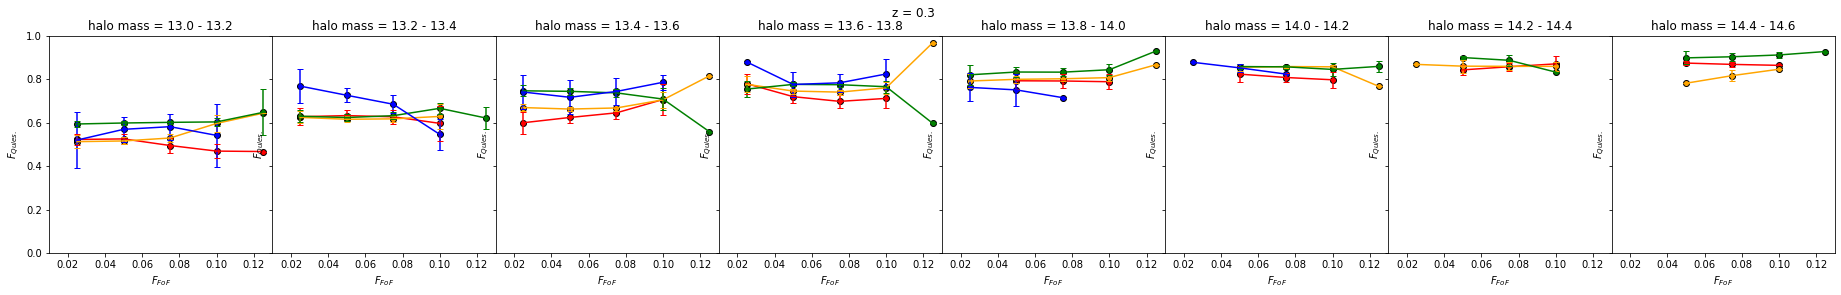

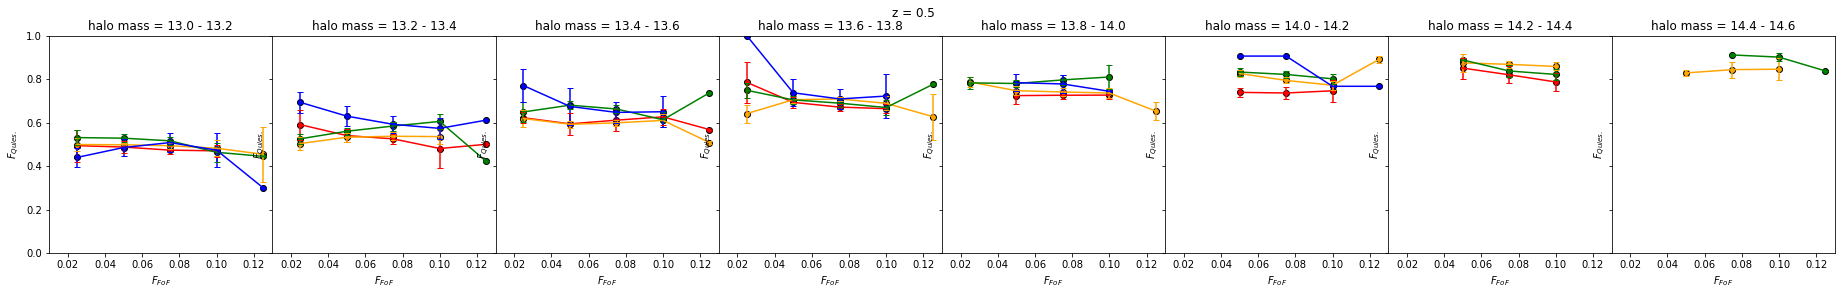

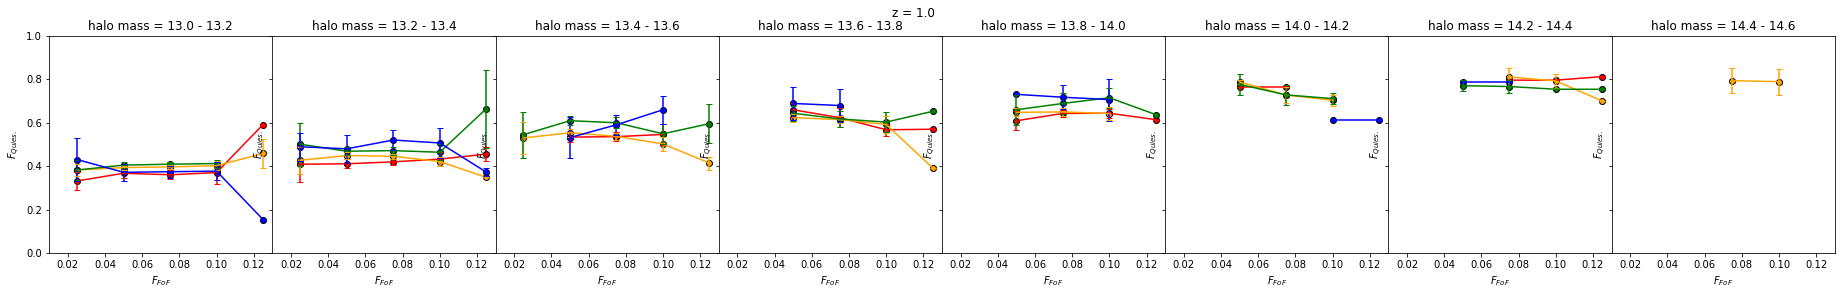

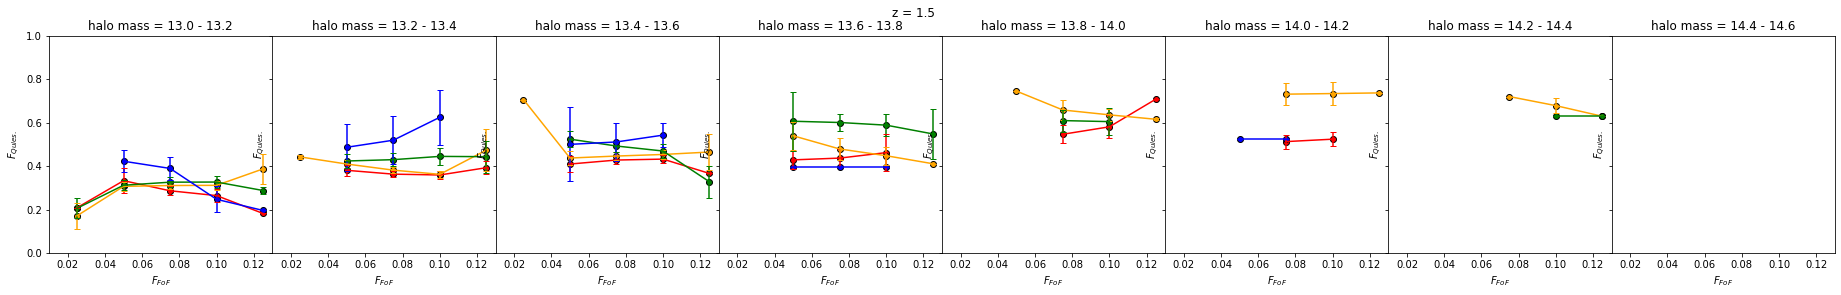

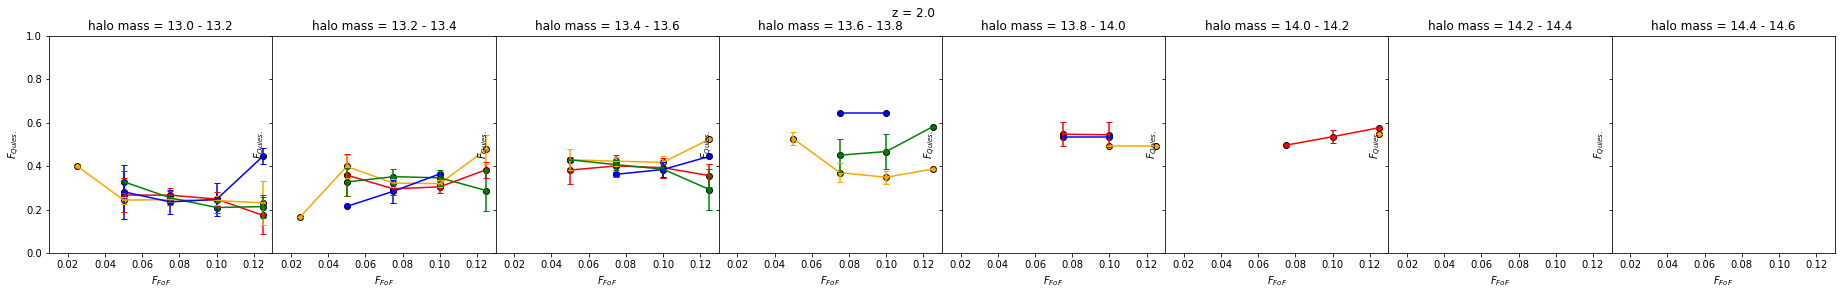

In [58]:
## 0.2 interval
mass_bins = np.arange(13.0, 14.6, 0.2)

for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 8, figsize = (32, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
        colors = ['red', 'orange', 'green', 'blue']
        for ic, c in enumerate(np.arange(2, 10, 2)):
            
            nmask = (num_mems >= 10)
            cmask = (cpars >= c) & (cpars < c + 2)
            
            mask = nmask & cmask
            
            #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
            fof_range = np.arange(0.025, 0.15, 0.025)
            fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            
            # bootstrap sampling
            fqs_median = []
            fqs_std = []
            
            for el in fqs_partial:
                
                if len(el) == 0:
                    fqs_median.append(np.nan)
                    fqs_std.append(np.nan)
                    continue
                
                meds = []
                
                for b in range(100):
                    bsamp = np.random.choice(el, size = len(el), replace = True)
                    meds.append(np.median(bsamp))
                    
                fqs_median.append(np.mean(meds))
                fqs_std.append(np.std(meds))
                
                    
#             fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
#             fqs_median = np.array(fqs_median)
            
            ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
            ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
            ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', color = colors[ic], capsize = 3)
    
    #####overall per mass, per concentration
#         mask = num_mems >= 10
        
#         fof_range = np.arange(0.025, 0.15, 0.025)
#         fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
        
#         fqs_median = []
#         fqs_std = []
        
#         for el in fqs_partial:

#             if len(el) == 0:
#                 fqs_median.append(np.nan)
#                 fqs_std.append(np.nan)
#                 continue

#             meds = []

#             for b in range(1000):
#                 bsamp = 


#                 meds.append(np.median(bsamp))

#             fqs_median.append(np.mean(meds))
#             fqs_std.append(np.std(meds))


#         ax[imbin].scatter(fof_range, fqs_median)
#         ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', capsize = 3)
        
#         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
#         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
#         ax[imbin].add_artist(anchor)
#         ax[imbin].legend()
        ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.2:.1f}')
        ax[imbin].set_xlabel('$F_{FoF}$')
        ax[imbin].set_ylabel('$F_{Quies.}$')
        
        ax[imbin].set_xlim(0.01, 0.13)
        ax[imbin].set_ylim(0, 1)

    fig.suptitle(f'z = {z:.1f}')

### 0.5 interval

In [61]:
mass_bins = np.arange(13.0, 14.5, 0.5)

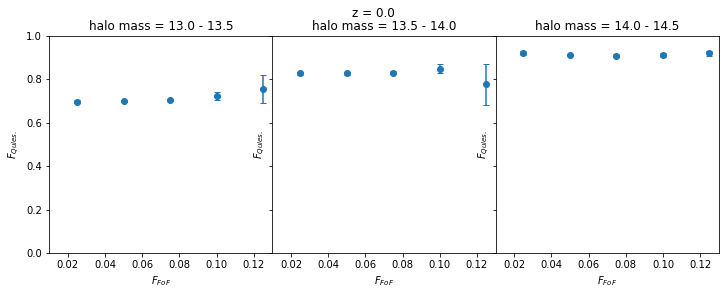

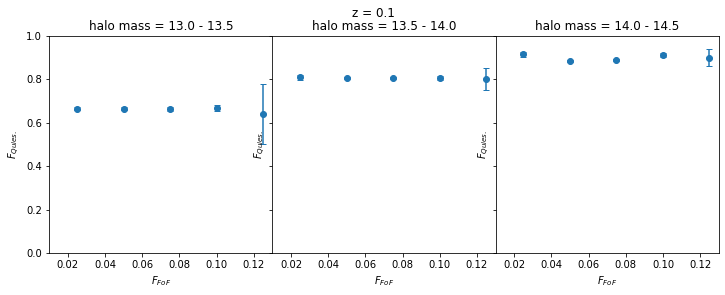

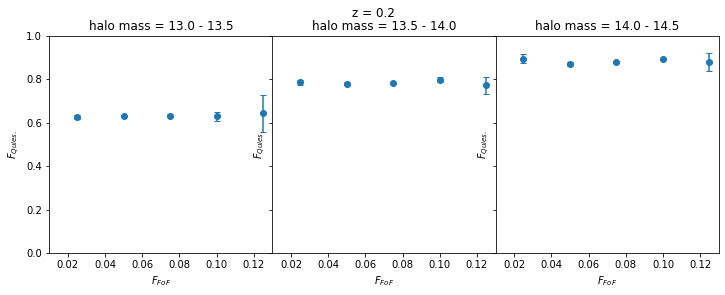

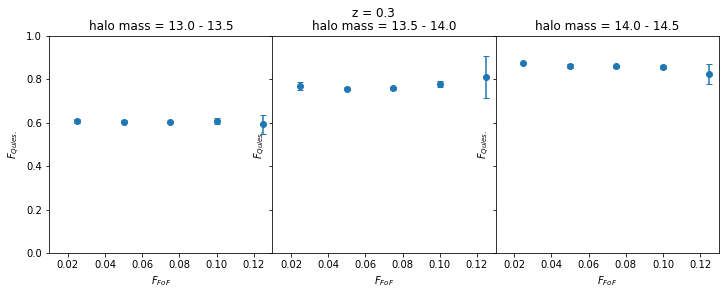

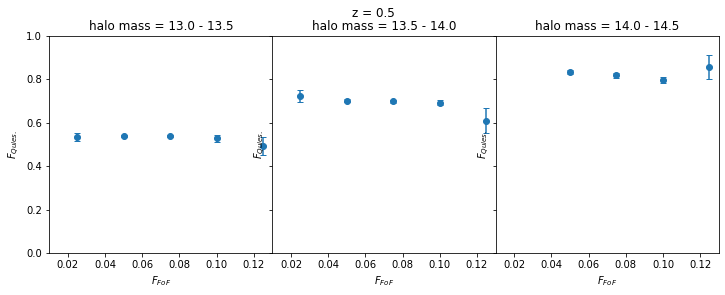

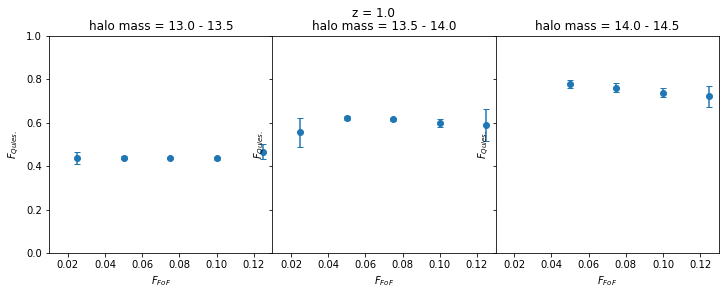

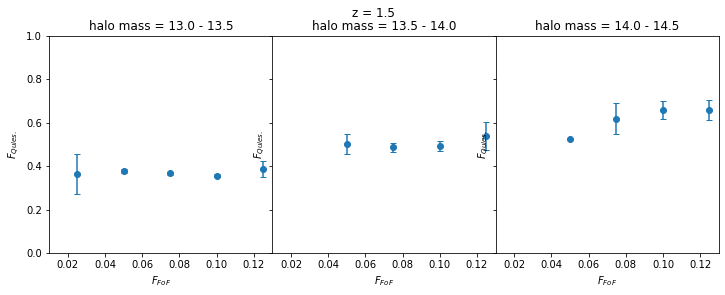

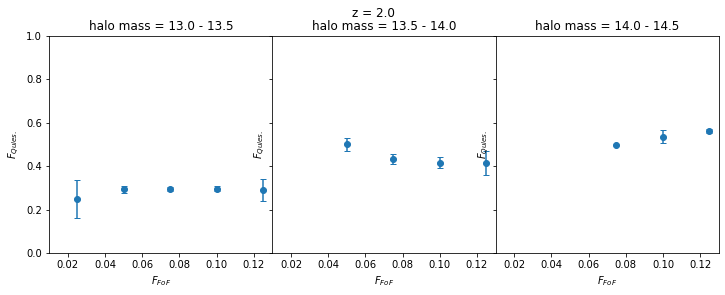

In [62]:
for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists2/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists2/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists2/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists2/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
#         colors = ['red', 'orange', 'green', 'blue']
#         for ic, c in enumerate(np.arange(2, 10, 2)):
            
#             nmask = (num_mems >= 10)
#             cmask = (cpars >= c) & (cpars < c + 2)
            
#             mask = nmask & cmask
            
#             #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
#             fof_range = np.arange(0.025, 0.15, 0.025)
#             fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            
#             # bootstrap sampling
#             fqs_median = []
#             fqs_std = []
            
#             for el in fqs_partial:
                
#                 if len(el) == 0:
#                     fqs_median.append(np.nan)
#                     fqs_std.append(np.nan)
#                     continue
                
#                 meds = []
                
#                 for b in range(1000):
#                     bsamp = np.random.choice(el)
#                     meds.append(np.median(bsamp))
                    
#                 fqs_median.append(np.mean(meds))
#                 fqs_std.append(np.std(meds))
                
                    
# #             fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
# #             fqs_median = np.array(fqs_median)
            
#             ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
#             ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
#             ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', color = colors[ic], capsize = 3)
    
    #####overall per mass, per concentration
        mask = num_mems >= 5
        
        fof_range = np.arange(0.025, 0.15, 0.025)
        fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
        
        fqs_median = []
        fqs_std = []
        
        for el in fqs_partial:

            if len(el) == 0:
                fqs_median.append(np.nan)
                fqs_std.append(np.nan)
                continue

            meds = []

            for b in range(1000):
                bsamp = np.random.choice(el, size = len(el), replace = True)
                meds.append(np.median(bsamp))

            fqs_median.append(np.mean(meds))
            fqs_std.append(np.std(meds))


        ax[imbin].scatter(fof_range, fqs_median)
        ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', capsize = 3)
        
#         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
#         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
#         ax[imbin].add_artist(anchor)
#         ax[imbin].legend()
        ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.5:.1f}')
        ax[imbin].set_xlabel('$F_{FoF}$')
        ax[imbin].set_ylabel('$F_{Quies.}$')
        
        ax[imbin].set_xlim(0.01, 0.13)
        ax[imbin].set_ylim(0, 1)
    
#     fig.supylabel('$F_{Quies.}$')
    fig.suptitle(f'z = {z:.1f}')

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  retu

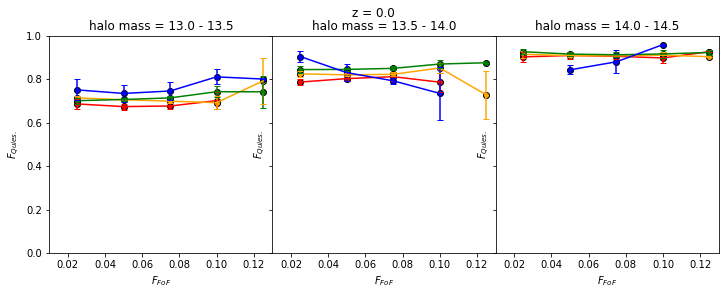

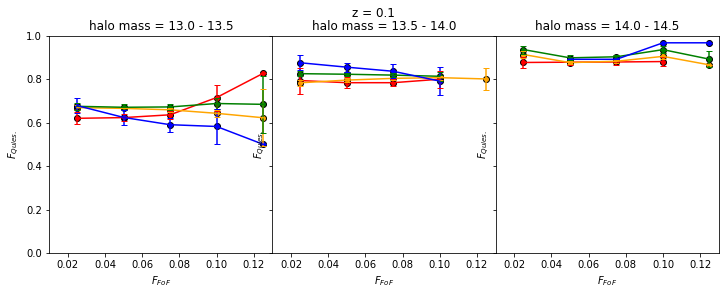

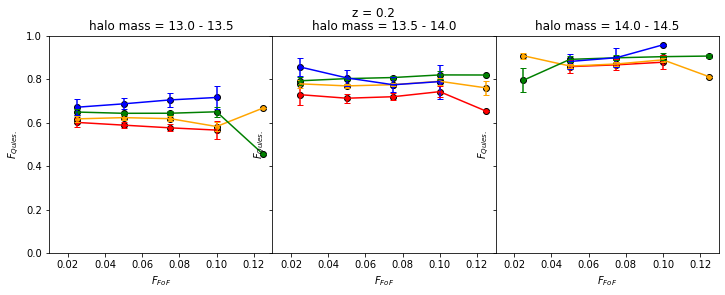

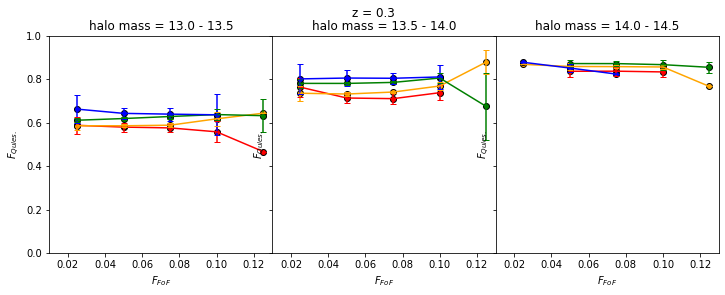

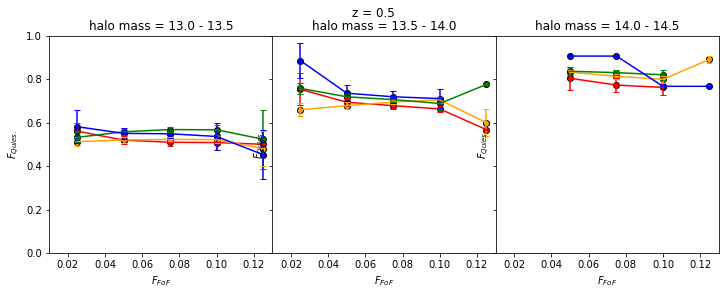

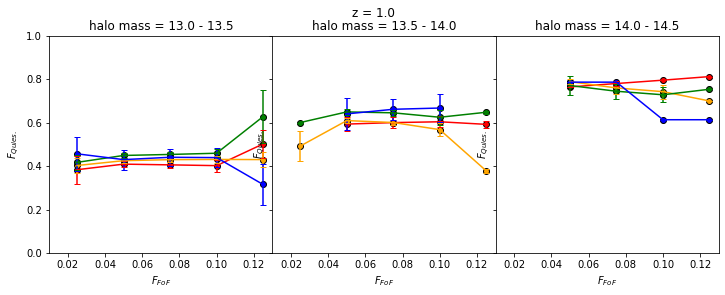

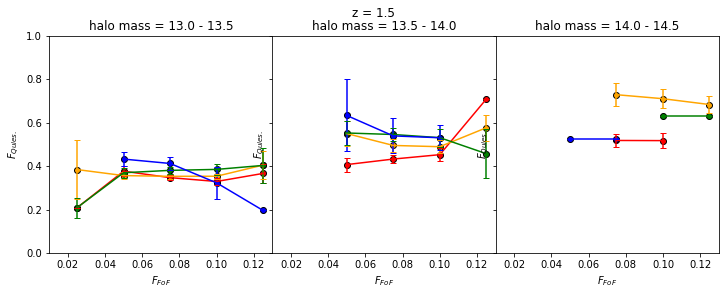

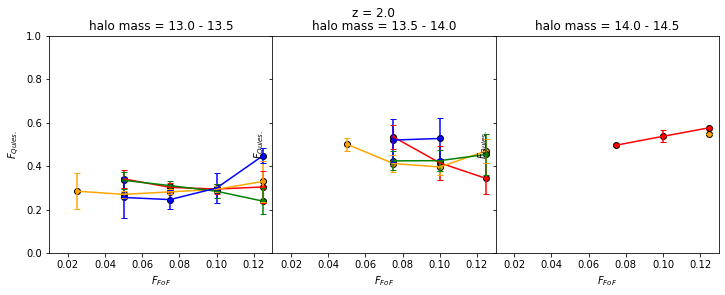

In [63]:
for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists2/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists2/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists2/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists2/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
        colors = ['red', 'orange', 'green', 'blue']
        for ic, c in enumerate(np.arange(2, 10, 2)):
            
            nmask = (num_mems >= 10)
            cmask = (cpars >= c) & (cpars < c + 2)
            
            mask = nmask & cmask
            
            #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
            fof_range = np.arange(0.025, 0.15, 0.025)
            fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            
            # bootstrap sampling
            fqs_median = []
            fqs_std = []
            
            for el in fqs_partial:
                
                if len(el) == 0:
                    fqs_median.append(np.nan)
                    fqs_std.append(np.nan)
                    continue
                
                meds = []
                
                for b in range(1000):
                    bsamp = np.random.choice(el, size = len(el), replace = True)
                    meds.append(np.median(bsamp))
                    
                fqs_median.append(np.mean(meds))
                fqs_std.append(np.std(meds))
                
                    
#             fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
#             fqs_median = np.array(fqs_median)
            
            ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
            ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
            ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', color = colors[ic], capsize = 3)
    
    #####overall per mass, per concentration
#         mask = num_mems >= 5
        
#         fof_range = np.arange(0.025, 0.15, 0.025)
#         fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
        
#         fqs_median = []
#         fqs_std = []
        
#         for el in fqs_partial:

#             if len(el) == 0:
#                 fqs_median.append(np.nan)
#                 fqs_std.append(np.nan)
#                 continue

#             meds = []

#             for b in range(1000):
#                 bsamp = np.random.choice(el)
#                 meds.append(np.median(bsamp))

#             fqs_median.append(np.mean(meds))
#             fqs_std.append(np.std(meds))


#         ax[imbin].scatter(fof_range, fqs_median)
#         ax[imbin].errorbar(fof_range, fqs_median, yerr = fqs_std, linestyle = '', capsize = 3)
        
#         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
#         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
#         ax[imbin].add_artist(anchor)
#         ax[imbin].legend()
        ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.5:.1f}')
        ax[imbin].set_xlabel('$F_{FoF}$')
        ax[imbin].set_ylabel('$F_{Quies.}$')
        
        ax[imbin].set_xlim(0.01, 0.13)
        ax[imbin].set_ylim(0, 1)
    
#     fig.supylabel('$F_{Quies.}$')
    fig.suptitle(f'z = {z:.1f}')

In [50]:
# fqs_partial

In [22]:
for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists2/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists2/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists2/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists2/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
#         mask = num_mems >= 10
        colors = ['red', 'orange', 'green', 'blue']
        for ic, c in enumerate(np.arange(2, 10, 2)):
            
            nmask = (num_mems >= 0)
            cmask = (cpars >= c) & (cpars < c + 2)
            
            mask = nmask & cmask
            
            #0.025, 0.050, 0.075, 0.100, 0.125, 0.15
            fof_range = np.arange(0.025, 0.15, 0.025)
            fqs_partial = [[fqs[mask][i] for i in range(len(fqs[mask])) if fofs[mask][i] >= fof - 0.025 and fofs[mask][i] < fof + 0.025] for fof in fof_range]
            fqs_median = [np.median(x) if len(x) >= 20 else np.nan for x in fqs_partial]
            fqs_median = np.array(fqs_median)
            
            ax[imbin].scatter(fof_range, fqs_median, color = colors[ic], edgecolor = 'black', label = f'c = {c} - {c+2}')
            ax[imbin].plot(fof_range, fqs_median, color = colors[ic])
        
#         ax[imbin].scatter(fofs[mask], fqs[mask], c = cpars[mask], cmap = 'gray', vmin = 0, vmax = 10)
        
#         corr, pval = stats.pearsonr(fofs[mask], fqs[mask])
#         anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
#         ax[imbin].add_artist(anchor)
        ax[imbin].legend()
        ax[imbin].set_title(f'halo mass = {mbin:.1f} - {mbin+0.5:.1f}')
        ax[imbin].set_xlabel('$F_{FoF}$')
        ax[imbin].set_ylabel('$F_{Quies.}$')
        
        ax[imbin].set_xlim(0.01, 0.13)
        ax[imbin].set_ylim(0, 1)
    fig.suptitle(f'z = {z:.1f}')

[[], [], [], [], []]

In [12]:
# fofs
mbin

14.0

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.09364063, 0.09705625, 0.10047188, 0.1038875 , 0.10730312,
        0.11071875, 0.11413438, 0.11755   , 0.12096563, 0.12438125,
        0.12779688]),
 <a list of 10 Patch objects>)

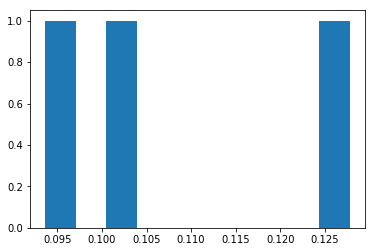

In [8]:
# fqs_partial
plt.hist(fofs, bins = 10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda

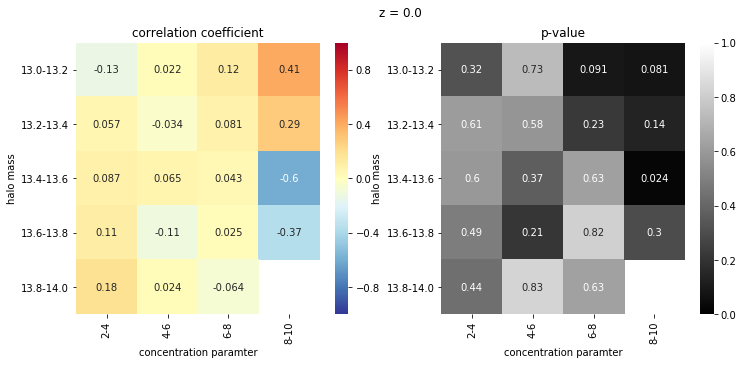

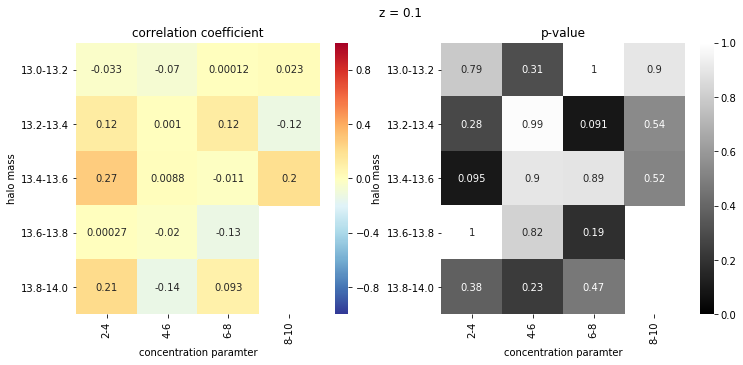

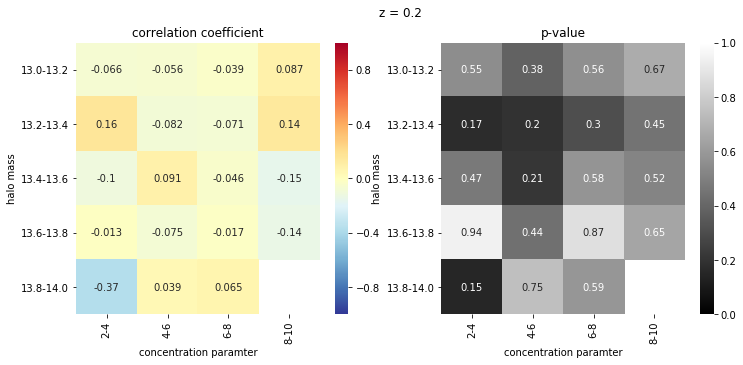

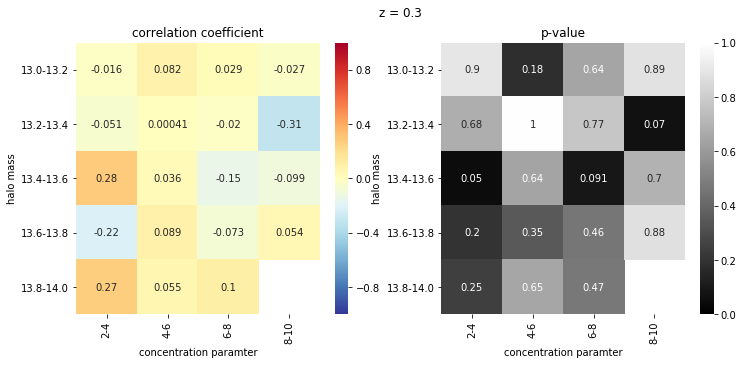

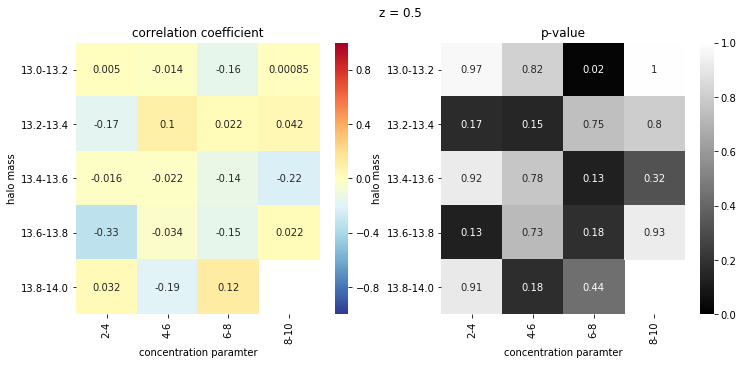

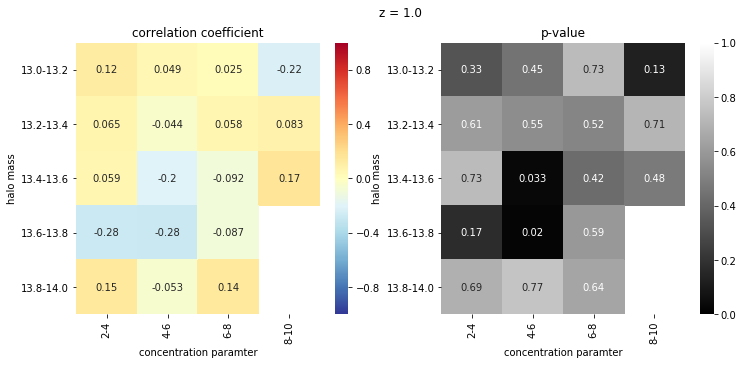

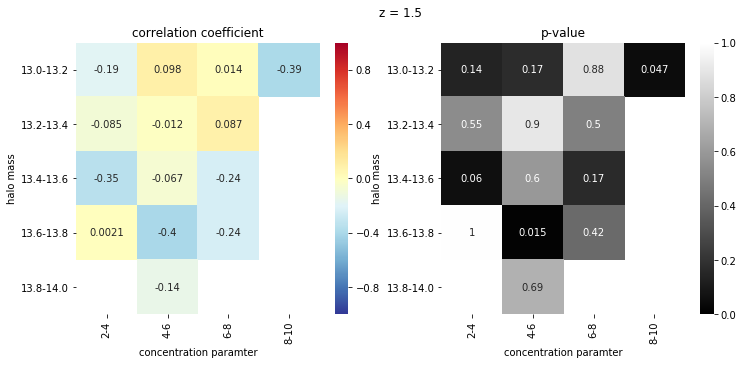

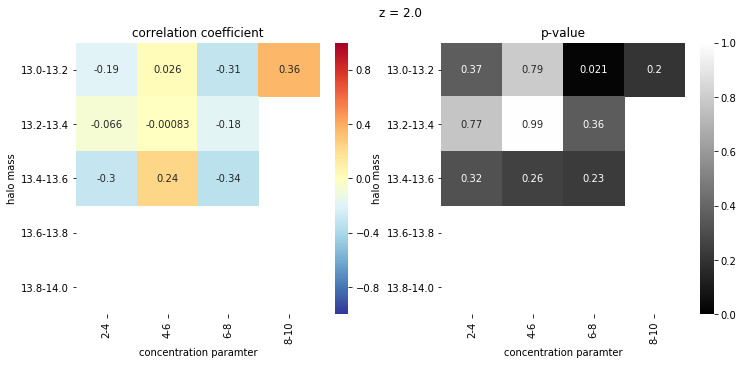

In [21]:
#correlation plot

for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
        
    corrmat = np.zeros((5, 4)) # halo mass x concentration
    pvalmat = np.zeros((5, 4))
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
#         mem_ids = np.array(mem_ids)
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
        for ic, c in enumerate(np.arange(2, 10, 2)):
            
            nmask = (num_mems >= 10)
            cmask = (cpars >= c) & (cpars < c + 2)
            
            
            final_mask = cmask & nmask
            corr, pval = stats.pearsonr(fofs[final_mask], fqs[final_mask])
            
            if sum(final_mask) >= 10:
                corrmat[imbin, ic] = corr
                pvalmat[imbin, ic] = pval
            else:
                corrmat[imbin, ic] = np.nan
                pvalmat[imbin, ic] = np.nan
    
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))
#     cax = ax.matshow(corrmat, vmin = -1, vmax = 1, cmap = 'gray')
    sns.heatmap(corrmat, 
                   annot = True,      # 실제 값 화면에 나타내기
                   cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
                   vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
                  ax = ax[0])
    
    sns.heatmap(pvalmat, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'gray',  # Red, Yellow, Blue 색상으로 표시
               vmin = 0, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              ax = ax[1])
    
    ax[0].set_xticklabels(['2-4', '4-6', '6-8', '8-10'], rotation = 90)
    ax[0].set_yticklabels(['13.0-13.2', '13.2-13.4', '13.4-13.6', '13.6-13.8', '13.8-14.0'], rotation = 0)
    ax[1].set_xticklabels(['2-4', '4-6', '6-8', '8-10'], rotation = 90)
    ax[1].set_yticklabels(['13.0-13.2', '13.2-13.4', '13.4-13.6', '13.6-13.8', '13.8-14.0'], rotation = 0)
    
    ax[0].set_xlabel('concentration paramter')
    ax[0].set_ylabel('halo mass')
    ax[1].set_xlabel('concentration paramter')
    ax[1].set_ylabel('halo mass')
    
    ax[0].set_title('correlation coefficient')
    ax[1].set_title('p-value')
    
    fig.suptitle(f'z = {z:.1f}')
#     significant_mask = pvalmat < 0.05 #text color = red 
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda

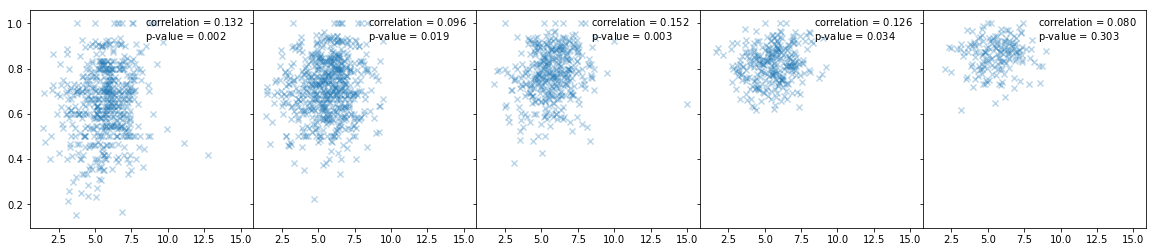

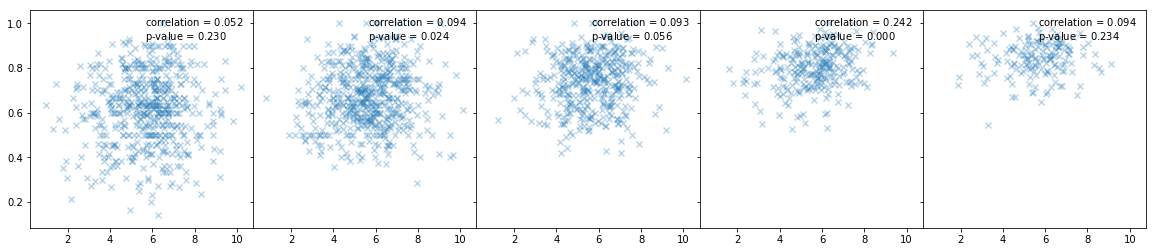

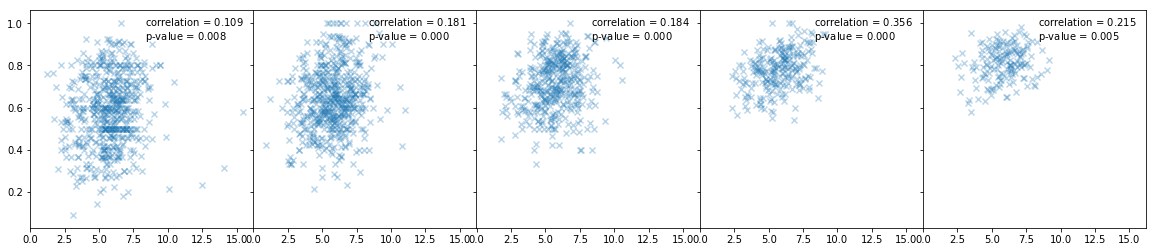

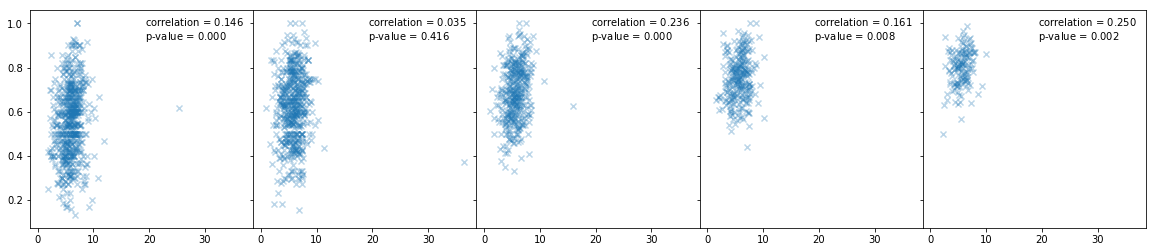

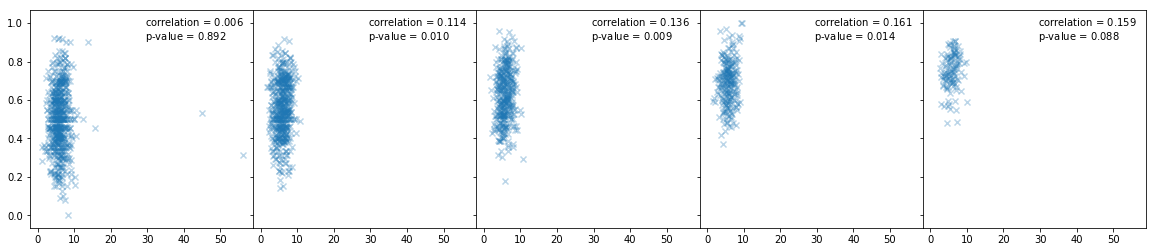

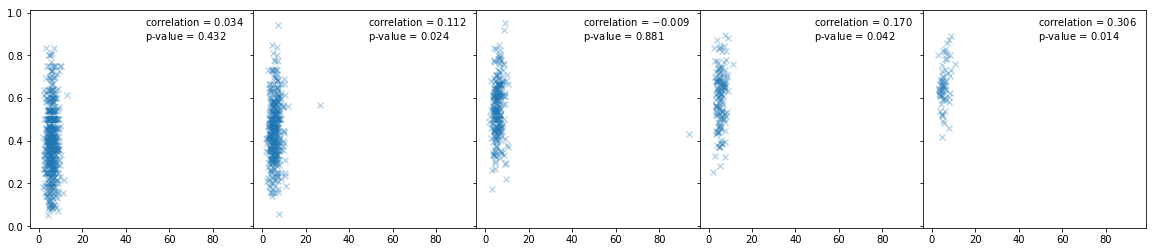

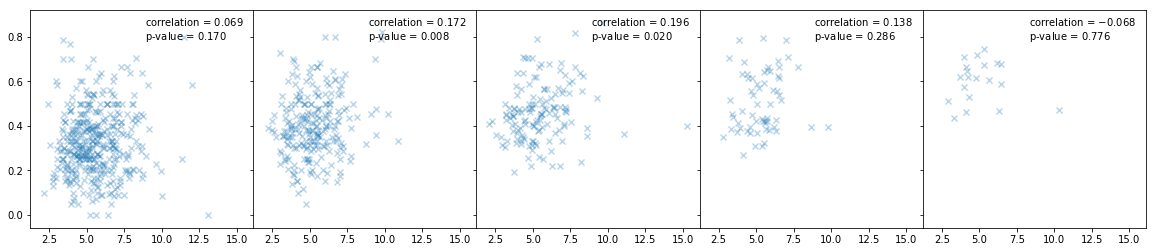

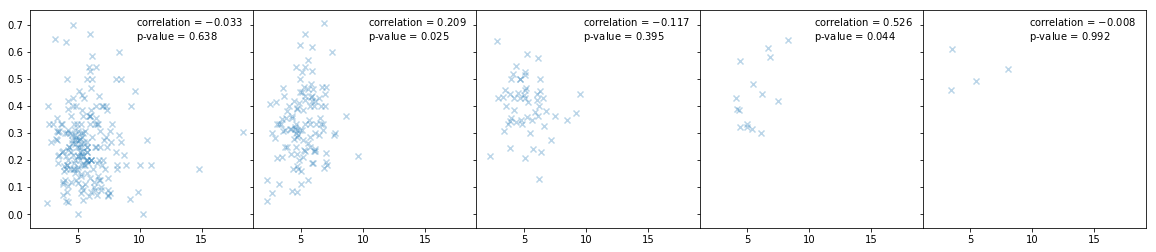

In [19]:
for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(1, 5, figsize = (20, 4), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists/mem_ids_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            mem_ids = pickle.load(f)
        
        with open(f'./lists/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
#         mem_ids = np.array(mem_ids)
        fofs = np.array(fofs)
        fqs = np.array(fqs)
        cpars = np.array(cpars)
        
        num_mems = [len(x) for x in mem_ids]
        num_mems = np.array(num_mems)
        
        mask = num_mems >= 10
        
        ax[imbin].scatter(cpars[mask], fqs[mask], alpha = .3, marker = 'x')
        
        corr, pval = stats.pearsonr(cpars[mask], fqs[mask])
        anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = False)
        ax[imbin].add_artist(anchor)

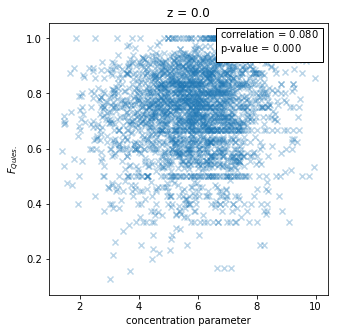

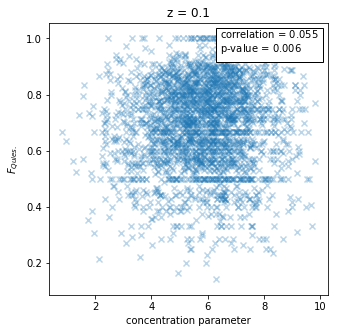

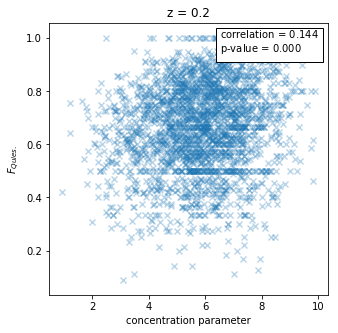

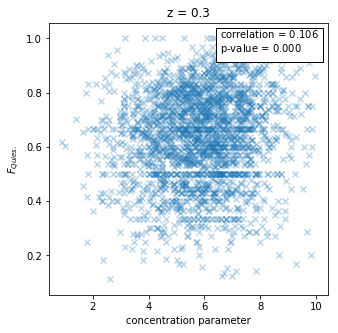

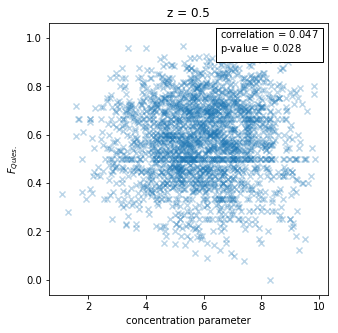

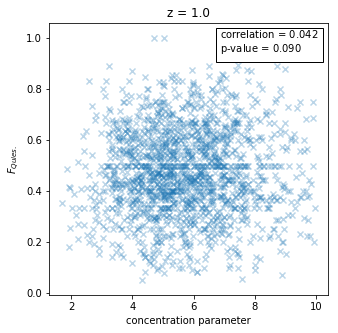

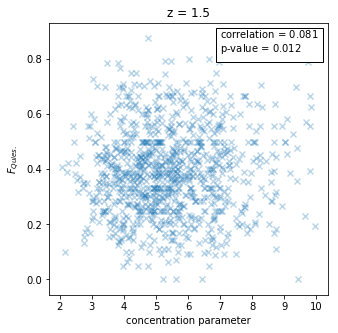

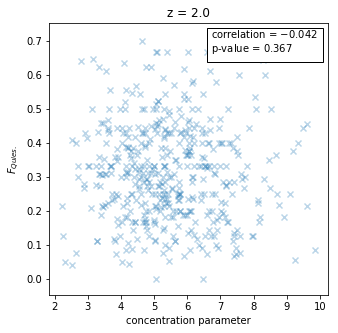

In [16]:
for isnap, snap in enumerate(snaps_full):
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]
    
    fig, ax = plt.subplots(figsize = (5, 5), sharex = True, sharey = True)
    fig.subplots_adjust(wspace = 0)
    
    fofs_total = []
    fqs_total = []
    cpars_total = []
    
    for imbin, mbin in enumerate(mass_bins):
        
        with open(f'./lists/fofs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fofs = pickle.load(f)
            
        with open(f'./lists/fqs_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            fqs = pickle.load(f)
            
        with open(f'./lists/cpars_snap{snap:03d}_mbin{mbin:.1f}', "rb") as f:
            cpars = pickle.load(f)
        
        fofs_total.extend(fofs)
        fqs_total.extend(fqs)
        cpars_total.extend(cpars)
        
    
    fofs_total = np.array(fofs_total)
    fqs_total = np.array(fqs_total)
    cpars_total = np.array(cpars_total)
    
    mask = cpars_total < 10
    
    ax.scatter(cpars_total[mask], fqs_total[mask], alpha = .3, marker = 'x')

    corr, pval = stats.pearsonr(cpars_total[mask], fqs_total[mask])
    anchor = AnchoredText(f'correlation = ${corr:.3f}$ \n' + f'p-value = ${pval:.3f}$', loc= 'upper right', prop = dict(size=10), frameon = True)
    ax.add_artist(anchor)
    
    ax.set_xlabel('concentration parameter')
    ax.set_ylabel('$F_{Quies.}$')
    
    ax.set_title(f'z = {z:.1f}')